In [105]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [106]:
# 2. Load dataset
data = pd.read_csv("D:\\Customer-Satisfaction-dashboard\\data\\customer_support_tickets.csv")
print(data.info())





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [107]:
print(data.head())

   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       22-03-2021  Technical issue   
1          Female       LG Smart TV       22-05-2021  Technical issue   
2           Other          Dell XPS       14-07-2020  Technical issue   
3          Female  Microsoft Office       13-11-2020  Billing inquiry   
4          Female  Autodesk AutoCAD       04-02-2020  Billing inquiry   

             Ticket Subject  \
0             Product setup   
1  Peripheral compatibil

In [108]:
# 3. Drop IDs / PII
data = data.drop(columns=["Ticket ID", "Customer Name", "Customer Email"])
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer Age                  8469 non-null   int64  
 1   Customer Gender               8469 non-null   object 
 2   Product Purchased             8469 non-null   object 
 3   Date of Purchase              8469 non-null   object 
 4   Ticket Type                   8469 non-null   object 
 5   Ticket Subject                8469 non-null   object 
 6   Ticket Description            8469 non-null   object 
 7   Ticket Status                 8469 non-null   object 
 8   Resolution                    2769 non-null   object 
 9   Ticket Priority               8469 non-null   object 
 10  Ticket Channel                8469 non-null   object 
 11  First Response Time           5650 non-null   object 
 12  Time to Resolution            2769 non-null   object 
 13  Cus

In [109]:
# 4. Handle Dates → Numeric
data["Date of Purchase"] = pd.to_datetime(data["Date of Purchase"], errors="coerce", format="%Y-%m-%d")
data["days_since_purchase"] = (pd.to_datetime("today") - data["Date of Purchase"]).dt.days
data = data.drop(columns=["Date of Purchase"])  # drop original datetime

In [110]:
# 5. Encode categorical variables
label_encoders = {}
for col in ["Customer Gender", "Product Purchased", "Ticket Type",
            "Ticket Status", "Ticket Priority", "Ticket Channel"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str).fillna("Unknown"))
    label_encoders[col] = le

In [111]:
# 6. NLP Features (TF-IDF)
tfidf = TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1,2))

ticket_text = data["Ticket Subject"].fillna("") + " " + data["Ticket Description"].fillna("")
text_features = tfidf.fit_transform(ticket_text)

In [112]:
# 7. Define Features & Target
X = data.drop(columns=["Customer Satisfaction Rating", "Ticket Subject", "Ticket Description", 
                       "Resolution", "First Response Time", "Time to Resolution"])
X = hstack([X.values, text_features])  # combine structured + text features
# Target column
y = data["Customer Satisfaction Rating"]

# Handle missing target values first
data = data[y.notnull()].copy()
y = data["Customer Satisfaction Rating"]

# Drop non-target columns
X_structured = data.drop(columns=[
    "Customer Satisfaction Rating", "Ticket Subject", "Ticket Description",
    "Resolution", "First Response Time", "Time to Resolution"
])

# TF-IDF on text
ticket_text = data["Ticket Subject"].fillna("") + " " + data["Ticket Description"].fillna("")
text_features = tfidf.fit_transform(ticket_text)

# Combine structured + text
X = hstack([X_structured.values, text_features])

In [113]:
# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [114]:
# 9. Impute missing values in structured features before training Random Forest
from sklearn.impute import SimpleImputer

# Impute missing values in X_structured (e.g., fill NaN with 0)
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_structured_imputed = imputer.fit_transform(X_structured)

# Recreate X with imputed structured features and text features
X_imputed = hstack([X_structured_imputed, text_features])

# Redo train-test split with imputed features
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
	X_imputed, y, test_size=0.2, random_state=42
)

rfc = RandomForestClassifier(
    random_state=42, 
    n_estimators=500,         # more trees for stability
    max_depth=20,             # prevent overfitting
    class_weight="balanced",  # handle imbalance
    n_jobs=-1                 # parallel training
)
rfc.fit(X_train_imp, y_train_imp)

c:\Users\Tanisha\miniconda3\Lib\site-packages\sklearn\impute\_base.py:574: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


,n_estimators,500
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [115]:
# 10. Evaluation
y_pred = rfc.predict(X_test_imp)
print("Accuracy:", accuracy_score(y_test_imp, y_pred))
print("\nClassification Report:\n", classification_report(y_test_imp, y_pred))


Accuracy: 0.21299638989169675

Classification Report:
               precision    recall  f1-score   support

         1.0       0.18      0.21      0.20       109
         2.0       0.20      0.21      0.20       117
         3.0       0.25      0.27      0.26       112
         4.0       0.24      0.19      0.22       108
         5.0       0.20      0.19      0.19       108

    accuracy                           0.21       554
   macro avg       0.21      0.21      0.21       554
weighted avg       0.21      0.21      0.21       554



In [116]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, X_imputed, y, cv=5, scoring="accuracy")
print("CV Mean Accuracy:", scores.mean())

CV Mean Accuracy: 0.2137967502497046


In [117]:
print(y.value_counts(normalize=True))


Customer Satisfaction Rating
3.0    0.209462
1.0    0.199711
2.0    0.198267
5.0    0.196461
4.0    0.196100
Name: proportion, dtype: float64


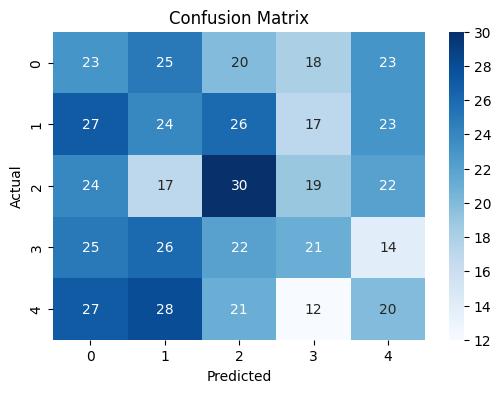

In [118]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

c:\Users\Tanisha\miniconda3\Lib\site-packages\sklearn\impute\_base.py:574: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Accuracy: 0.21299638989169675

Classification Report:
               precision    recall  f1-score   support

         1.0       0.18      0.21      0.20       109
         2.0       0.20      0.21      0.20       117
         3.0       0.25      0.27      0.26       112
         4.0       0.24      0.19      0.22       108
         5.0       0.20      0.19      0.19       108

    accuracy                           0.21       554
   macro avg       0.21      0.21      0.21       554
weighted avg       0.21      0.21      0.21       554



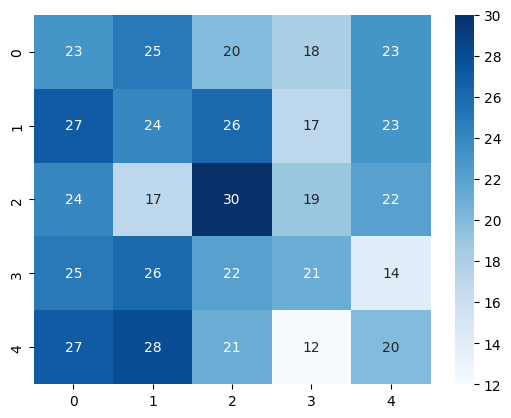

In [119]:
# TF-IDF Features with more richness
tfidf = TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1,2))
ticket_text = data["Ticket Subject"].fillna("") + " " + data["Ticket Description"].fillna("")
text_features = tfidf.fit_transform(ticket_text)

# Impute structured features (same as before)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_structured_imputed = imputer.fit_transform(X_structured)

# Combine structured + text
X_imputed = hstack([X_structured_imputed, text_features])

# Train-test split
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Optimized Random Forest
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1
)

rfc.fit(X_train_imp, y_train_imp)

# Evaluation
y_pred = rfc.predict(X_test_imp)
print("Accuracy:", accuracy_score(y_test_imp, y_pred))
print("\nClassification Report:\n", classification_report(y_test_imp, y_pred))
sns.heatmap(confusion_matrix(y_test_imp, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()


In [122]:
# 1. Import libraries
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.


Original dataset shape: (8469, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority            

c:\Users\Tanisha\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:11:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4007220216606498

Classification Report:
               precision    recall  f1-score   support

        High       0.42      0.47      0.44       217
         Low       0.41      0.49      0.44       221
     Neutral       0.27      0.10      0.15       116

    accuracy                           0.40       554
   macro avg       0.37      0.35      0.35       554
weighted avg       0.38      0.40      0.38       554



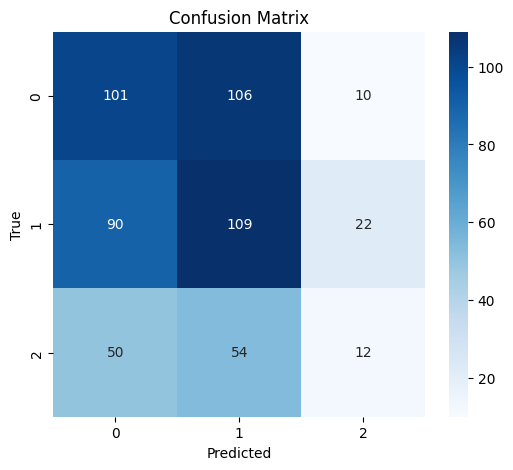

In [126]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from xgboost import XGBClassifier

# 2. Load dataset
data = pd.read_csv("D:\\Customer-Satisfaction-dashboard\\data\\customer_support_tickets.csv")
print("Original dataset shape:", data.shape)
print(data.info())

# 3. Drop IDs / PII
data = data.drop(columns=["Ticket ID", "Customer Name", "Customer Email"], errors="ignore")

# 4. Handle Dates → Numeric
data["Date of Purchase"] = pd.to_datetime(data["Date of Purchase"], errors="coerce", format="%Y-%m-%d")
data["days_since_purchase"] = (pd.to_datetime("today") - data["Date of Purchase"]).dt.days
data = data.drop(columns=["Date of Purchase"], errors="ignore")

# 5. Encode categorical columns
label_encoders = {}
for col in ["Customer Gender", "Product Purchased", "Ticket Type",
            "Ticket Status", "Ticket Priority", "Ticket Channel"]:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str).fillna("Unknown"))
        label_encoders[col] = le

# 6. NLP Features (TF-IDF on text)
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
ticket_text = data["Ticket Subject"].fillna("") + " " + data["Ticket Description"].fillna("")
text_features = tfidf.fit_transform(ticket_text)

# 7. Define Features & Target
X = data.drop(columns=["Customer Satisfaction Rating", "Ticket Subject", "Ticket Description", 
                       "Resolution", "First Response Time", "Time to Resolution"], errors="ignore")
X = hstack([X.values, text_features])
y = data["Customer Satisfaction Rating"]

# 8. Handle missing target values (drop NaN in y)
not_null_mask = y.notnull()
X = X.tocsr()[not_null_mask.values]
y = y[not_null_mask]

# Optional: Collapse ratings into 3 classes (Low / Neutral / High) for better accuracy
y = y.replace({1: "Low", 2: "Low", 3: "Neutral", 4: "High", 5: "High"})

# 9. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 10. Encode target labels for XGBoost
le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_test_enc = le_y.transform(y_test)

# 11. Train Gradient Boosting (XGBoost)
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1,
    objective="multi:softmax"
)
xgb.fit(X_train, y_train_enc)

# 12. Evaluation
y_pred_enc = xgb.predict(X_test)
y_pred = le_y.inverse_transform(y_pred_enc)

print("Accuracy:", accuracy_score(y_test_enc, y_pred_enc))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [128]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Use integer-encoded labels for XGBoost
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))

xgb = XGBClassifier(
    n_estimators=800,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1,   # for binary only
    objective="multi:softmax"
)

# Pass encoded labels and corresponding sample weights
xgb.fit(X_train, y_train_enc, sample_weight=[class_weights[label] for label in y_train_enc])


c:\Users\Tanisha\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:16:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [130]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": [300, 500, 800],
    "max_depth": [6, 10, 14],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBClassifier(objective="multi:softmax", random_state=42, n_jobs=-1),
    param_distributions=params,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=2
)

search.fit(X_train, y_train_enc)
print("Best Parameters:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=14, n_estimators=300, subsample=1.0; total time=  51.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=14, n_estimators=300, subsample=1.0; total time=  45.9s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=14, n_estimators=300, subsample=1.0; total time=  46.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=14, n_estimators=800, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=14, n_estimators=800, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=14, n_estimators=800, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.8; total time=  26.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.8; total time=  28.5s
[CV] 